In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
ls_api_key      = os.getenv("LANGSMITH_API_KEY")
ls_endpoint     = os.getenv("LANGSMITH_ENDPOINT")
ls_project      = os.getenv("LANGSMITH_PROJECT")
ls_tracing_flag = os.getenv("LANGSMITH_TRACING", "false").lower() == "true"

llm = init_chat_model("openai:gpt-4.1-mini",openai_api_key=api_key)

In [2]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to user's request."
    )

structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does type of programming language can increase performance services?")
print("1. :", output.search_query)
print("2. :", output.justification)

1. : how programming language type affects performance of services
2. : The user wants to understand how different types of programming languages can increase the performance of services. This query focuses on the relationship between programming language types and service performance, which will provide relevant information on this topic.


In [3]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


llm_with_tool = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tool.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_GojTUxYzEASdChTTS4HKNiOS',
  'type': 'tool_call'}]

Each LLM call processes the output of the previous one:
- E.g., when decomposing a task into multiple LLM calls has benefit.

Example:
- Take a topic, LLM makes a joke, check the joke, improve it twice.

In [8]:
from typing_extensions import TypedDict

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [11]:
# Nodes
def generate_joke(state: State):

    msg = llm.invoke(f"Write a short joke about {state["topic"]}")
    return { "joke": msg.content }

def improve_joke(state: State):

    msg = llm.invoke(f"Make this joke funier by adding wordplay: {state["joke"]}")
    return { "improved_joke": msg.content }

def polish_joke(state: State):

    msg = llm.invoke(f"Add a suprising twist to this joke: {state["improved_joke"]}")
    return { "final_joke": msg.content }

def check_punchline(state: State):

    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

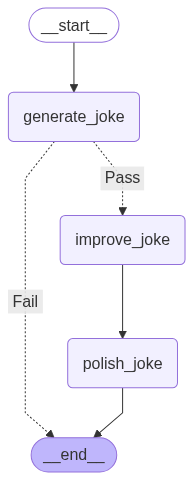

In [12]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add Edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, { "Pass": "improve_joke", "Fail": END }
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [10]:
state = chain.invoke({"topic": "cats"})
print("Initial Joke:")
print(state["joke"])
print("\n\n----------\n\n")

if "improved_joke" in state:
    print("Improved Joke:")
    print(state["improved_joke"])
    print("\n\n----------\n\n")

    print("Final Joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no puchline detected!")

Initial Joke:
Why don’t cats play poker in the jungle?  
Too many cheetahs!


----------


Improved Joke:
Why don’t cats play poker in the jungle?  
Because there are too many cheetahs—and they always paws the game to sneak a peek!


----------


Final Joke:
Why don’t cats play poker in the jungle?  
Because there are too many cheetahs—and they always paws the game to sneak a peek!  
But the real surprise? The parrots are the best bluffs—they never let a single secret fly!


Sub-tasks can be parallelized.
- E.g., when you want multi-perspectives for one task multi-query (RAG).
- E.g., when independent taks can be performed w/ different prompt.

Example:
- Take a topic, create a joke, story, and poem

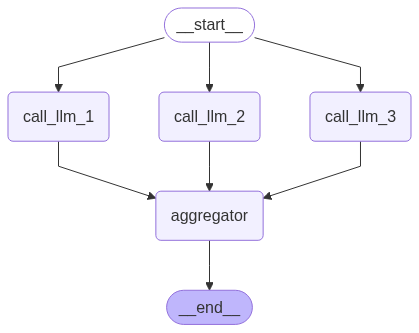

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a quiet village nestled between rolling hills, there lived a curious cat named Luna. Luna was no ordinary cat; she had fur that shimmered silver under the moonlight and eyes that sparkled like stars. Every night, while the village slept, Luna would embark on adventures through the moonlit streets.

One evening, as she wandered near the old oak tree in the village square, Luna spotted a tiny, frightened kitten hiding among the roots. The kitten was trembling and lost. Luna gently approached and nuzzled the little one, comforting her with soft purrs.

Determined to help, Luna carried the kitten through the village, searching for her family. Along the way, they met other cats—Whiskers, a wise old tabby; Misty, a playful calico; and Shadow, a sleek black cat who moved like a whisper in the dark. Together, the cats formed a small clan, united by their friendship and the mission to find the kitten's home.

Their journey l

In [13]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing

Routing classifies an input and directs it to a followup task. As noted in the Anthropic blog on Building Effective Agents:

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.



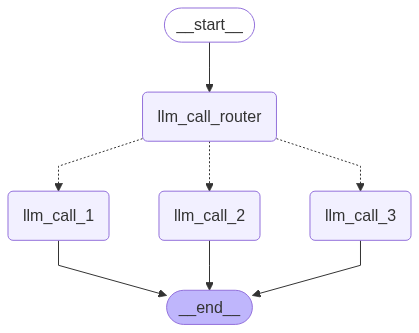

In moonlit nights and sunlit days,  
Silent paws in gentle ways,  
Whiskered kings and queens of grace,  
Mysteries wrapped in velvet face.  

Eyes that gleam like emerald fire,  
Curled in comfort, never tire,  
Purring songs, a soothing stream,  
Living life within a dream.  

Chasing shadows, playful, sly,  
Leaping softly, swift and spry,  
Guardians of hearth and heart,  
In every home, a work of art.  

Oh, the cat—both wild and tame,  
Forever free, yet calls our name,  
A friend, a muse, a soft refrain,  
In feline form, pure joy’s domain.


In [16]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])

### Evaluator Optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop:

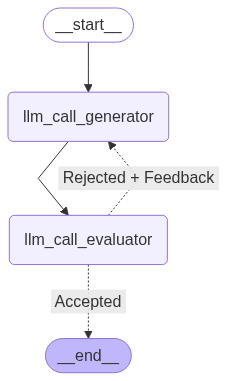

Why don’t cats play poker in the jungle?  
Too many cheetahs!


In [17]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])